# Quick Start

Here's a quick tutorial for those in a rush!

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import hemcee

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import numpy as np
import corner

First, specifiy the log probability (doesn't have to be normalized)
of your target distribution.
In this case, let's start with a simple Gaussian.

In [4]:
def log_prob(x):
    return - 0.5 * jnp.einsum('j,j->', x, x)

Now we can initalize the sampler. There are two types of samplers `hemcee.HamiltonianEnsembleSampeler` and `hemcee.EnsembleSampler`.
The `HamiltonianEnsembleSampler` implements the derivative-based algorithms detailed in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987), and the `EnsembleSampler` implements the derivative-free algorithms detailed in [Goodman & Weare (2010)](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf) (for python implementation see [`emcee`](https://emcee.readthedocs.io/en/stable/))

Let's start with the novel part of this package...

## `HamiltonianEnsembleSampler`
In Chen's paper, he details a couple of affine invariant sampling scheme. He comes to the conclusion that the walk move (Algorithm 3 in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987)) performs the best overall, so our package defaults to that.

In [5]:
dim = 3
total_chains = 20

# Hamiltonian Monte Carlo hyperparameters
step_size: float = 0.1 # Step size of leapfrog integrator
L: int = 10            # Number of leapfrog steps

# Inintalize the sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim, # <- dimension of the probability distribution
    log_prob=log_prob, # <- log probability goes here!
    step_size=step_size,
    L=L,
)

Now, we can run the sampler!

In [11]:
key = jax.random.PRNGKey(2)
keys = jax.random.split(key, 2)

inital_states = jax.random.normal(keys[0], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[1], # <- JAX is used under the hood, so we need to pass in a `key`
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
    show_progress=True,
)
print('Diagnostics:')
print(sampler.diagnostics_main)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)

Using 20 total chains: Group 1 (10), Group 2 (10)
Starting warmup...


100%|██████████| 603/603 [00:04<00:00, 122.14it/s]


Warmup complete.
Starting main sampling...


100%|██████████| 603/603 [00:04<00:00, 132.20it/s]


Main sampling complete.
Diagnostics:
{'accepts': Array([79715., 79557., 79410., 79289., 79353., 79435., 79564., 79492.,
       79500., 79588., 78890., 78352., 78712., 78643., 78658., 78398.,
       78745., 78547., 78693., 78607.], dtype=float64), 'acceptance_rate': Array([0.79715, 0.79557, 0.7941 , 0.79289, 0.79353, 0.79435, 0.79564,
       0.79492, 0.795  , 0.79588, 0.7889 , 0.78352, 0.78712, 0.78643,
       0.78658, 0.78398, 0.78745, 0.78547, 0.78693, 0.78607],      dtype=float64)}
Integrated autocorrelation time:
[2.49549417 1.86765043 1.98811028]


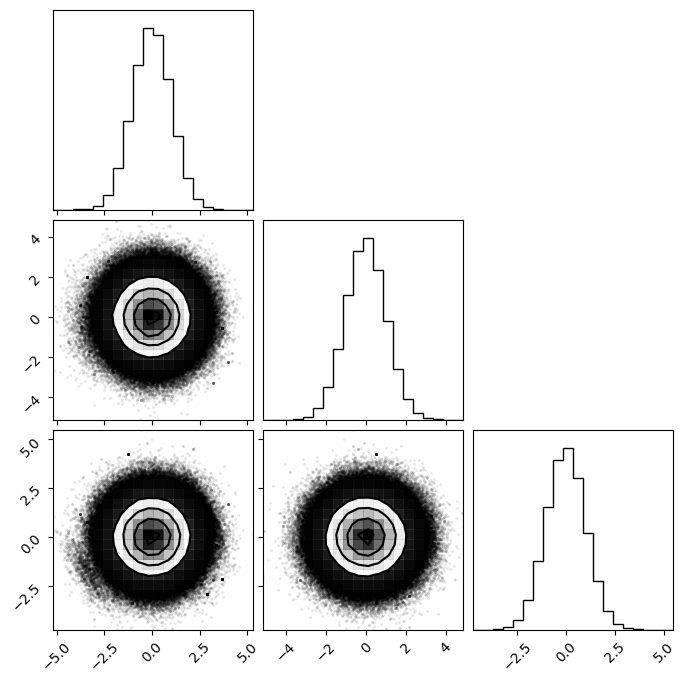

In [12]:
# Visualize results using `corner`
_ = corner.corner(np.array(samples.reshape(-1, dim)))

But this is way too easy, let's try to sample a highly skewed distribution! Due to our procedures being affine-invariant, your sampler won't fail in such regimes.

In [13]:
# Settings
dim = 7
total_chains = dim * 6
cond_number = 1000 # Condition number of covariance matrix

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)


# Distribution
eigenvals = 0.1 * jnp.linspace(1, cond_number, dim)
H = jax.random.normal(keys[0], shape=(dim, dim))
Q, _ = np.linalg.qr(H)
precision = Q @ np.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)

true_mean = jax.random.normal(keys[1], shape=(dim,))
precision_matrix = jnp.array(precision)

def log_prob(x):
    """Vectorized log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = - 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=0.1,
    L=10,
)

inital_states = jax.random.normal(keys[2], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[3],
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)


Using 42 total chains: Group 1 (21), Group 2 (21)
Starting warmup...
Warmup complete.
Starting main sampling...
Main sampling complete.
Integrated autocorrelation time:
[1.59599066 1.5985152  1.59357205 1.59361634 1.59771702 1.60277702
 1.59601622]


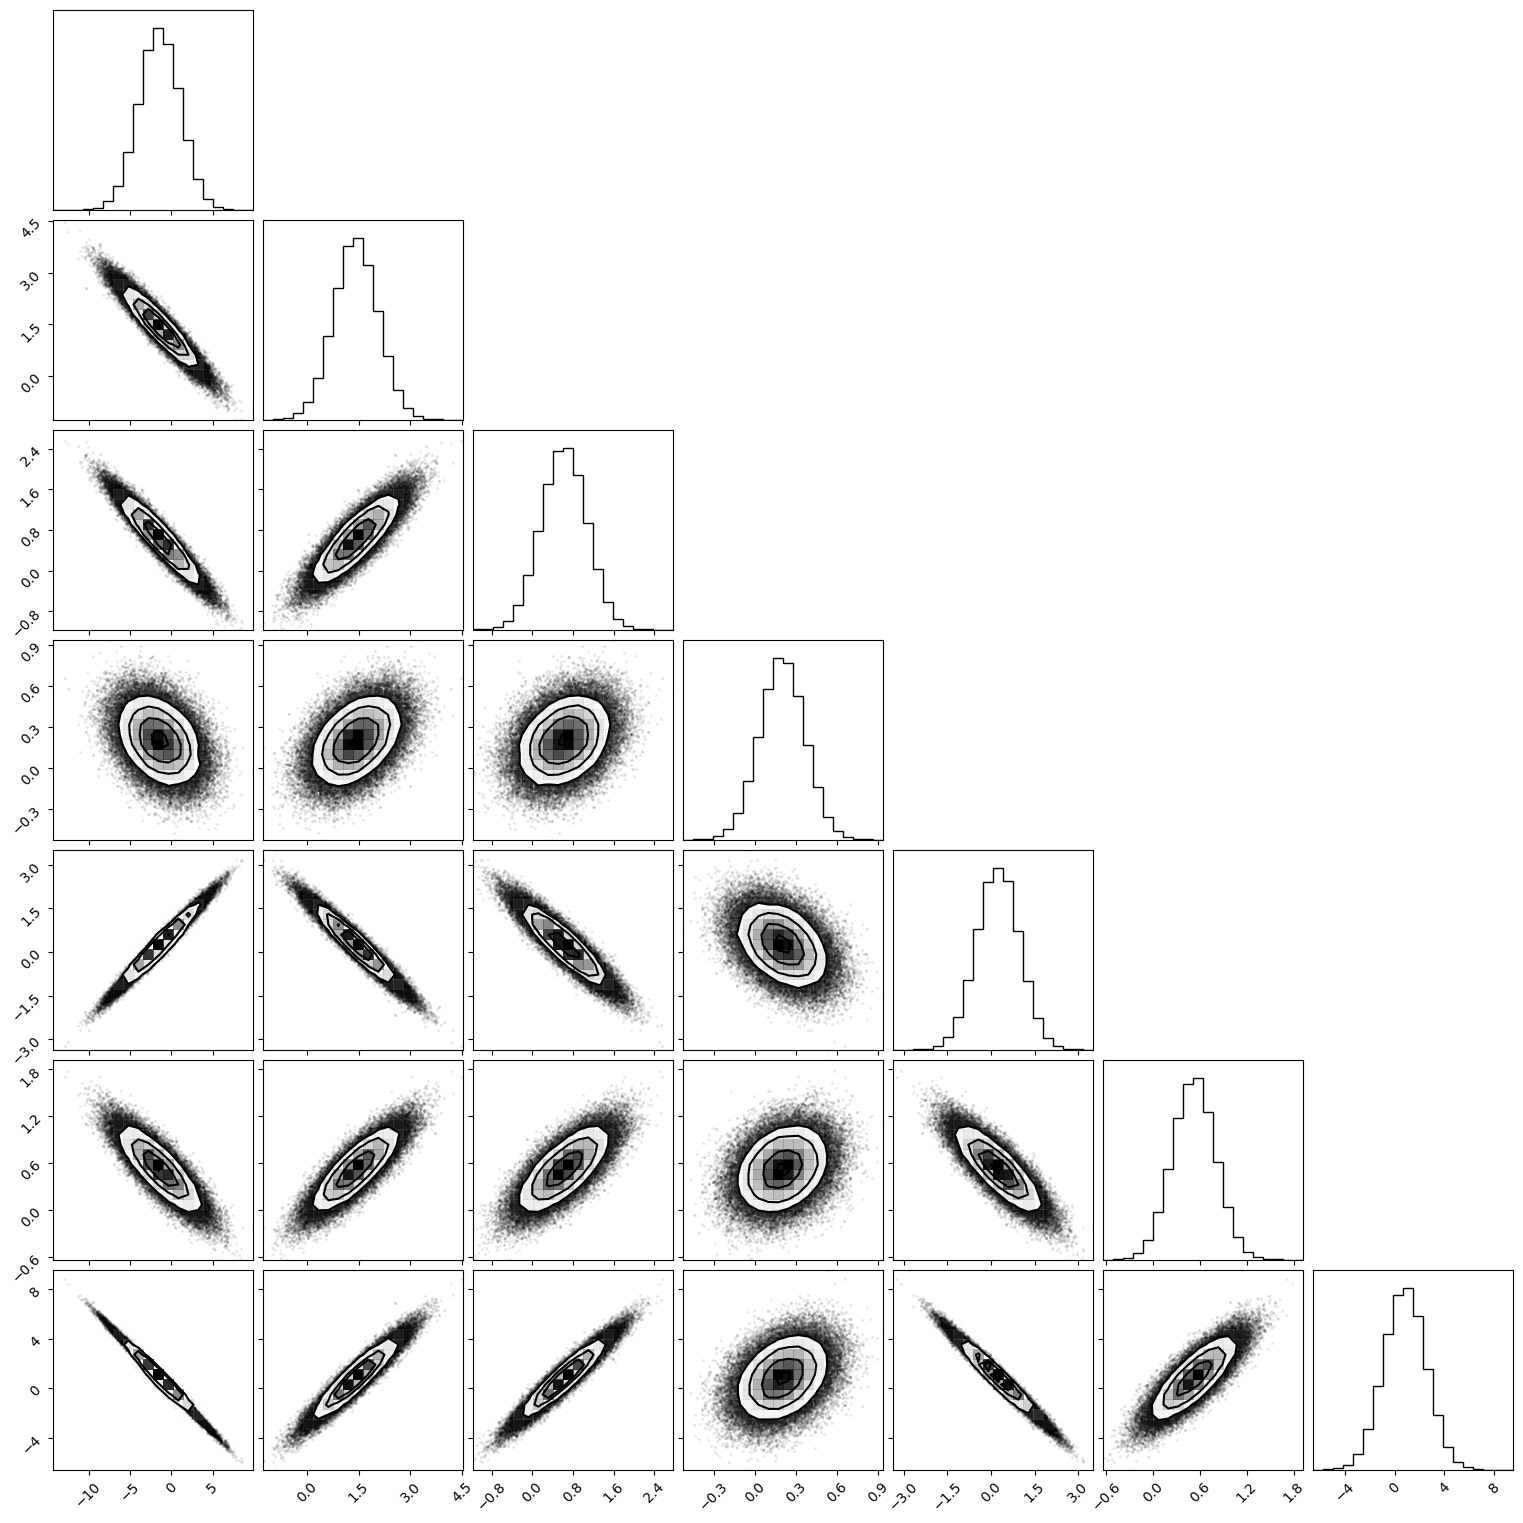

In [14]:
n_show = 100000 # Makes plotting faster
_ = corner.corner(np.array(samples.reshape(-1, dim))[:n_show])

You 

In [ ]:
from hemcee.moves.vanilla.stretch import stretch_move

sampler = hemcee.EnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    move=stretch_move, # Defaults to `stretch_move`, which is the default in `emcee`
)

samples = sampler.run_mcmc(
    key=jax.random.PRNGKey(0),
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)


In [ ]:
_ = corner.corner(np.array(samples.reshape(-1, dim)))